# Segmenting Lung X-ray Images with the Segment Anything Model
### Advanced Deep Learning 2022
Notebook written by [Jakob Ambsdorf](mailto:jaam@di.ku.dk).
Lung x-ray code originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).
SAM related code (c) Meta Platforms, Inc. and affiliates.

We consider the data described in:
Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006

## Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-yl7ibj_x
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-yl7ibj_x
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=c188326e8c5c83e9894a8c43613c0c5b4250ee5e0a32ec1bd50f04f4572e5db6
  Stored in directory: /tmp/pip-ephem-wheel-cache-pljzss2v/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
--2025-12-17 13:37:57--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


# Download model checkpoint
The checkpoint is 2.39GB, takes a few minutes for most bandwidths

In [6]:
import urllib.request
import os
from tqdm import tqdm

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
filename = "sam_vit_h_4b8939.pth"
folder = "models"

os.makedirs(folder, exist_ok=True)

filepath = os.path.join(folder, filename)

if not os.path.exists(filepath):
    # Get the file size before downloading
    file_size = int(urllib.request.urlopen(url).info().get("Content-Length", -1))

    # Start the download with progress bar
    with tqdm(unit="B", unit_scale=True, unit_divisor=1024, total=file_size, desc=filename, ncols=80) as pbar:
        urllib.request.urlretrieve(url, filepath, reporthook=lambda b, bsize, t: pbar.update(bsize))
else:
    print("Checkpoint file already exists. Skipping download.")

sam_vit_h_4b8939.pth: 2.39GB [00:14, 176MB/s]                                   


In [7]:
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Chest X-ray Dataset

In [8]:
import os
from torchvision.datasets.utils import download_url

In [9]:
# Mount Google drive
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Google drive not mounted


In [10]:
# If you are getting a download error, comment in the following lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [11]:
# Load database with chest X-rays with lung segmentations.
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
    download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
    print('Using existing', data_fn)

100%|██████████| 80.9M/80.9M [00:04<00:00, 19.0MB/s]


In [12]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

In [13]:
def map_interval(image, from_min, from_max, to_min, to_max):
    """
    Map values from [from_min, from_max] to [to_min, to_max]
    """
    from_range = from_max - from_min
    to_range = to_max - to_min
    # scaled = np.array((image - from_min) / float(from_range), dtype=float)
    scaled = (image - from_min) / float(from_range)
    return to_min + (scaled * to_range)

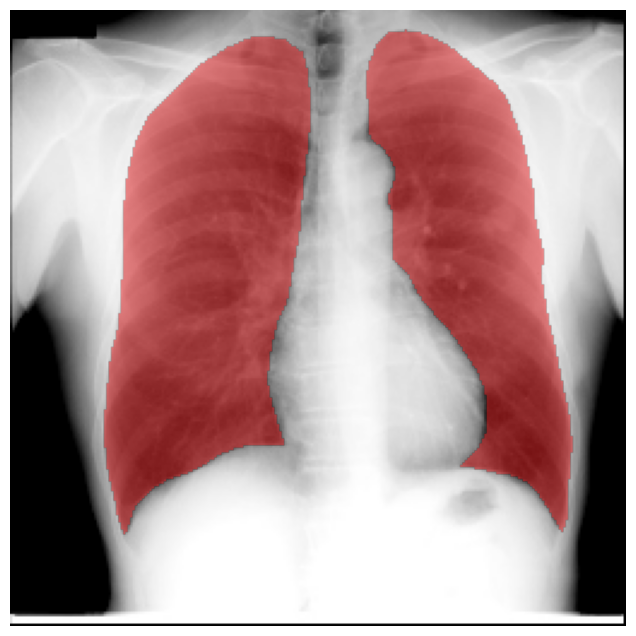

In [31]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)

# TODO:
# Bring images into the correct format for SAM:
# Image shape: (N, H, W, C=3)
# Mask shape: (N, H, W)
# Values: [0, 255] (uint8)

# YOUR CODE HERE

# Helper function to process images and masks
def process_images_and_masks(images, masks):
    # Ensure images are 3 channels and uint8 [0, 255]
    # First, flatten the last dimension if it's 1, as the loaded data likely has a (N, H, W, 1) shape.
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1) # (N, H, W)

    # Get min and max of the current image data for scaling to [0, 255]
    # The original values are floats (possibly normalized), so we map their current range to [0, 255].
    current_min = np.min(images)
    current_max = np.max(images)
    # If the image is flat (all pixels are the same value), current_min == current_max, which can cause division by zero.
    # Handle this case by setting the range to avoid division by zero or use a default range.
    if current_max == current_min:
        # If all values are the same, map them all to 127 (mid-gray) for uint8 representation
        images = np.full_like(images, 127.0)
    else:
        images = map_interval(images, current_min, current_max, 0, 255)

    images = images.astype(np.uint8)

    # Repeat the single channel to make it 3 channels (RGB) for SAM
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) # (N, H, W, 3)

    # Ensure masks are (N, H, W) and uint8
    if masks.shape[-1] == 1:
        masks = masks.squeeze(axis=-1) # (N, H, W)
    masks = masks.astype(np.uint8) # Masks are typically 0 or 1, converting to uint8 is appropriate.

    return images, masks

x_train, y_train = process_images_and_masks(x_train, y_train)
x_val, y_val = process_images_and_masks(x_val, y_val)
x_test, y_test = process_images_and_masks(x_test, y_test)


# your data should pass the following asserts
assert x_train.shape == (112, 256, 256, 3)
assert y_train.shape == (112, 256, 256)
assert x_val.shape == (12, 256, 256, 3)
assert y_val.shape == (12, 256, 256)
assert x_test.shape == (123, 256, 256, 3)
assert y_test.shape == (123, 256, 256)

assert x_train.dtype == y_train.dtype == np.uint8
assert np.min(x_train) == 0
assert np.max(x_train) == 255

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

# Single Example image

Let's try to run SAM on a single example image

In [41]:
## Point example

In [94]:
example_img, example_mask = x_train[0], y_train[0]

input_points = np.array([[75, 100], [180, 100]]) # TODO: Pick appropriate input points
input_label = np.array([1,1]) # TODO: Pick appropriate input labels = where the value is 1 (lung area)

example_img.shape

(256, 256, 3)

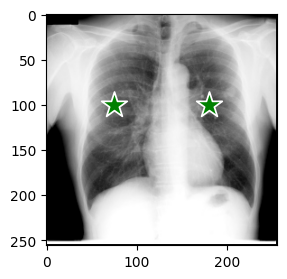

In [95]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_points(input_points, input_label, plt.gca()) # You may also use other prompt methods!
plt.axis('on')
plt.show()

In [96]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_label,
    multimask_output=True,
)

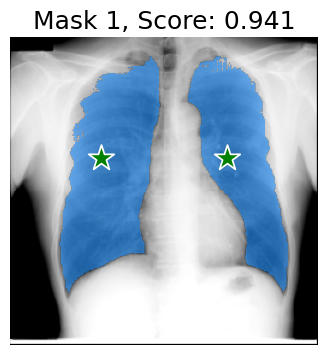

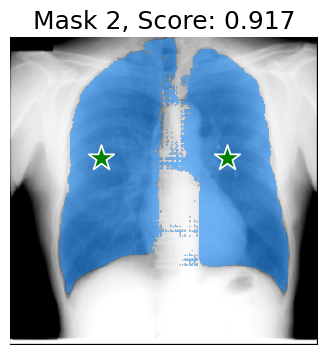

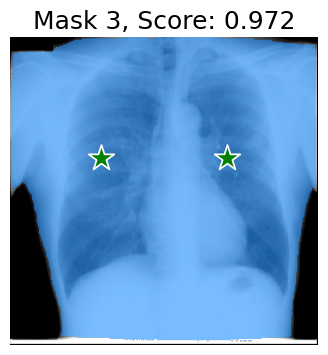

In [97]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_mask(mask, plt.gca())
    show_points(input_points, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

## Box prompting

In [98]:
example_img, example_mask = x_train[0], y_train[0]

input_box = np.array([20, 210, 230, 10]) # TODO: Pick appropriate input points
input_label = np.array([1]) # TODO: Pick appropriate input labels = where the value is 1 (lung area)

example_img.shape

(256, 256, 3)

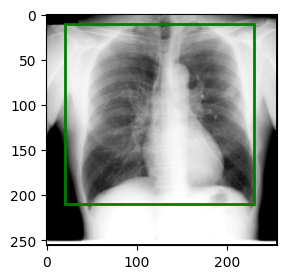

In [99]:
plt.figure(figsize=(3,3))
plt.imshow(example_img)
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

In [100]:
predictor.set_image(example_img)

masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=True,
)

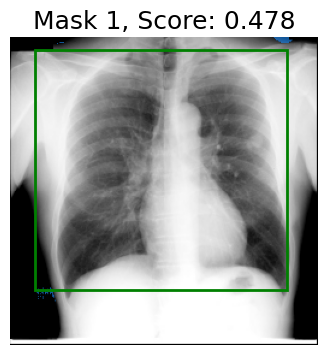

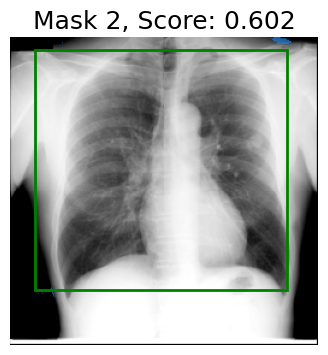

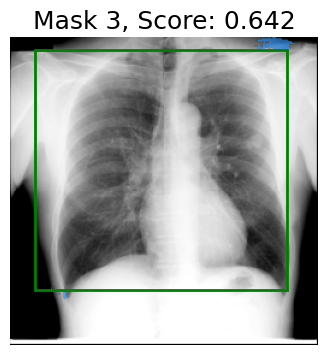

In [101]:
# Note that the "score" here is an estimation of the mask quality, not the quality of the segmentation compared to the ground truth.
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(4,4))
    plt.imshow(example_img.squeeze())
    show_box(input_box, plt.gca())
    show_mask(mask, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Evaluation loop

In [29]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.4 MB/s eta 0:00:00


In [113]:
import torchmetrics
f1 = torchmetrics.F1Score(task="binary")

f1_scores = []

input_points = np.array([[75, 100], [180, 100]]) # TODO: Pick appropriate input points
input_label = np.array([1,1]) # TODO: Pick appropriate input labels = where the value is 1 (lung area)

for img, mask_gt in zip(x_val, y_val):
  predictor.set_image(img)

  masks, scores, logits = predictor.predict(
      point_coords=input_points,
      point_labels=input_label,
      multimask_output=True,
  )

  # Convert masks and mask_gt to torch.Tensor and ensure consistent shape and type
  # masks will be (1, H, W), mask_gt is (H, W)
  # Squeeze masks to (H, W) and convert both to long tensors for F1Score
  pred_tensor = masks[0].squeeze()
  target_tensor = mask_gt.squeeze()

  f1_scores.append(f1(pred_tensor, target_tensor).item())



mean_f1 = np.mean(f1_scores) # TODO: Compute mean F1 score
std_f1 = np.std(f1_scores) # TODO: Compute standard deviation of F1 scores

print(f"Mean F1 score: {mean_f1:.4f}")
print(f"Standard deviation: {std_f1:.4f}")

TypeError: _unique2(): argument 'input' (position 1) must be Tensor, not numpy.ndarray